In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
n_in = 168 #历史数量
n_out = 1 #预测数量
n_features = 1
# n_test = 1
n_val = 1
n_epochs = 250

In [3]:
#d导入数据
def load_stw_data() -> pd.DataFrame:
    
    df_stw = pd.read_excel('data3.xlsx')
    df_stw.columns = ['BillingDate', 'VolumnHL']
    
    return df_stw

In [5]:
#MinMaxScaler数据归一化，可以帮助网络模型更快的拟合，稍微有一些提高准确率的效果
def minmaxscaler(data: pd.DataFrame) -> pd.DataFrame:
    
    volume = data.VolumnHL.values
    volume = volume.reshape(len(volume), 1)
    volume = scaler.fit_transform(volume)
    volume = volume.reshape(len(volume),)    
    data['VolumnHL'] = volume
        
    return data

In [6]:
#划分训练数据集和验证数据集,这里需要注意的是我么需要预测的数据是不可以出现在训练中的，切记。
def split_data(x, y, n_test: int):
    
    x_train = x[:-n_val-n_out+1]
    x_val = x[-n_val:]
    y_train = y[:-n_val-n_out+1]
    y_val = y[-n_val:]
    
    return x_train, y_train, x_val, y_val

In [7]:
#划分X和Y
def build_train(train, n_in, n_out):
    
    train = train.drop(["BillingDate"], axis=1)
    X_train, Y_train = [], []
    for i in range(train.shape[0]-n_in-n_out+1):
        X_train.append(np.array(train.iloc[i:i+n_in]))
        Y_train.append(np.array(train.iloc[i+n_in:i+n_in+n_out]["VolumnHL"]))
        
    return np.array(X_train), np.array(Y_train)

In [21]:
#构建最简单的LSTM
def build_lstm(n_in: int, n_features: int):
    
    model = Sequential()
    model.add(LSTM(12, activation='relu', input_shape=(n_in, n_features)))
    model.add(Dropout(0.3))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mae')
    
    return model

In [8]:
#模型拟合
def model_fit(x_train, y_train, x_val, y_val, n_features):
    
    model = build_lstm(
        n_in   = n_in,
        n_features= 1
    )
    model.compile(loss='mae', optimizer='adam')
    model.fit(x_train, y_train, epochs=n_epochs, batch_size=128, verbose=1,  validation_data=(x_val, y_val))
    m = model.evaluate(x_val, y_val)
    print(m)
    
    return model

In [12]:
data = load_stw_data()
scaler = MinMaxScaler(feature_range=(0, 1))
data = minmaxscaler(data)
data


BillingDate  VolumnHL
0     2020100100  0.716253
1     2020100101  0.681873
2     2020100102  0.660723
3     2020100103  0.503664
4     2020100104  0.220000
..           ...       ...
739   2020103119  0.903540
740   2020103120  0.950066
741   2020103121  0.928116
742   2020103122  0.839933
743   2020103123  0.754007

[744 rows x 2 columns]

In [30]:
data_copy = data.copy()
x, y = build_train(data_copy, n_in, n_out)
x_train, y_train, x_val, y_val = split_data(x, y, n_val)
model = build_lstm(n_in, 1)
model = model_fit(x_train, y_train, x_val, y_val, 1)
predict = model.predict(x_val)  

Epoch 1/250
5/5 [==============================] - 1s 87ms/step - loss: 0.5972 - val_loss: 0.7531
Epoch 2/250
5/5 [==============================] - 0s 34ms/step - loss: 0.5847 - val_loss: 0.7406
Epoch 3/250
5/5 [==============================] - 0s 34ms/step - loss: 0.5738 - val_loss: 0.7284
Epoch 4/250
5/5 [==============================] - 0s 34ms/step - loss: 0.5645 - val_loss: 0.7165
Epoch 5/250
5/5 [==============================] - 0s 37ms/step - loss: 0.5526 - val_loss: 0.7047
Epoch 6/250
5/5 [==============================] - 0s 36ms/step - loss: 0.5447 - val_loss: 0.6932
Epoch 7/250
5/5 [==============================] - 0s 34ms/step - loss: 0.5312 - val_loss: 0.6818
Epoch 8/250
5/5 [==============================] - 0s 34ms/step - loss: 0.5215 - val_loss: 0.6708
Epoch 9/250
5/5 [==============================] - 0s 33ms/step - loss: 0.5083 - val_loss: 0.6578
Epoch 10/250
5/5 [==============================] - 0s 34ms/step - loss: 0.4930 - val_loss: 0.6358
Epoch 11/250
5/5 [=

In [31]:

# predict = model.predict(x_val)  
validation = scaler.inverse_transform(predict)[0]
validation


array([658555.25], dtype=float32)

In [28]:
validation = scaler.inverse_transform(predict)
actual = scaler.inverse_transform(y_val)[0]
validation


array([[627431.7 , 602337.44, 568625.7 , 532946.75, 496093.03, 470566.06,
        465113.47, 467931.44, 481032.06, 491785.28, 516215.03, 542771.25,
        566388.56, 588022.25, 609117.75, 646578.1 , 668284.7 , 683520.9 ,
        706767.9 , 721522.44, 720074.8 , 709097.25, 688215.6 , 661669.5 ]],
      dtype=float32)

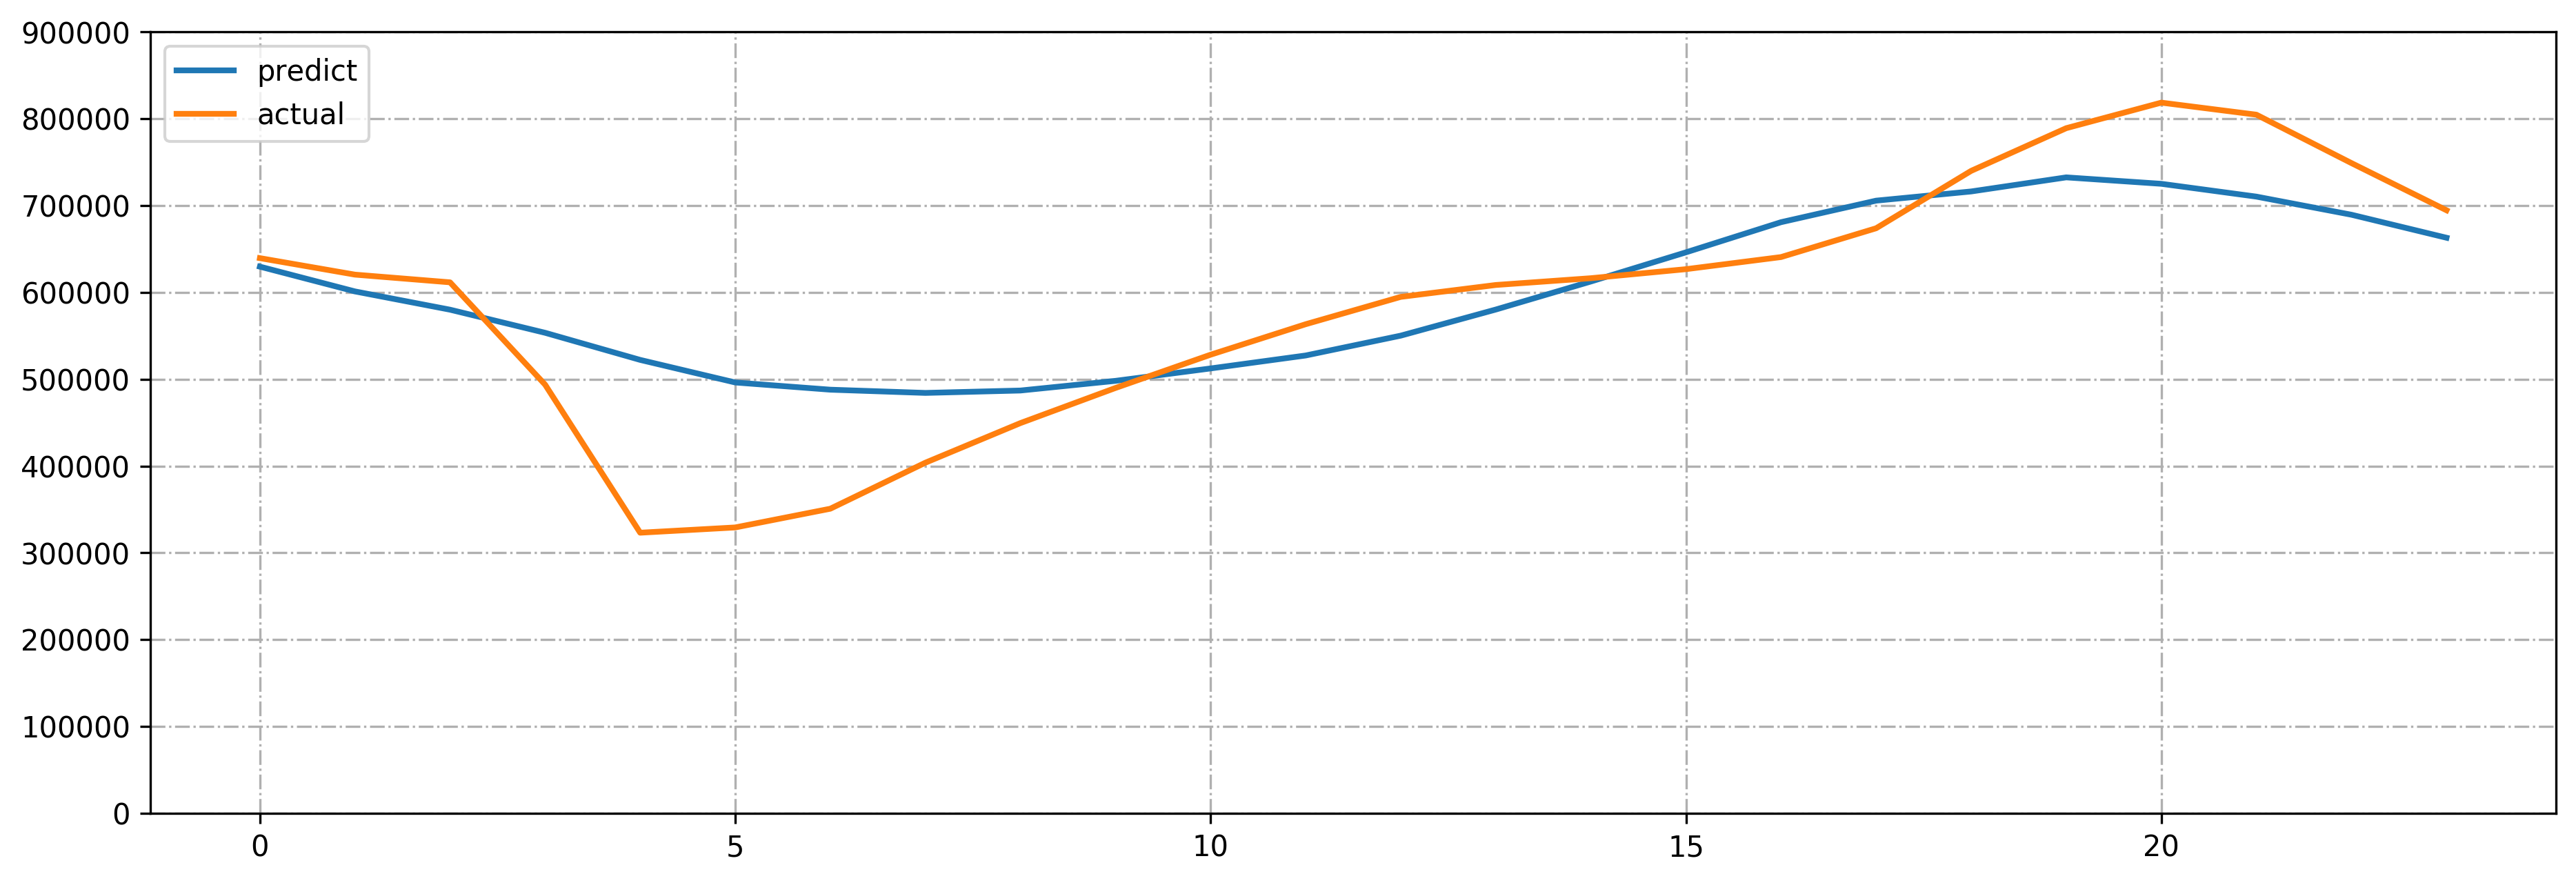

In [121]:
predict = validation
actual = actual
x = [x for x in range(24)]
fig, ax = plt.subplots(figsize=(15,5),dpi = 300)
ax.plot(x, predict, linewidth=2.0,label = "predict")
ax.plot(x, actual, linewidth=2.0,label = "actual")
ax.legend(loc=2);
# ax.set_title(bf_name)
plt.ylim((0, 900000))
plt.grid(linestyle='-.')
plt.show()

In [114]:
#ACC
error = 0
summery = 0
for i in range(24):
    error += abs(predict[i] - actual[i])
    summery += actual[i]
acc = 1 - error/summery
acc

0.8520669472132617

In [3]:
from PySide6.QtWidgets import QPushButton,QTabBar, QLabel,QApplication,QLayout,QMainWindow,QVBoxLayout,QHBoxLayout,QSizePolicy
from PySide6.QtGui import QPainter,QAction,QKeyEvent
from PySide6.QtCore import QFile,QDate,Qt,Slot
# Copyright (C) 2022 The Qt Company Ltd.
# SPDX-License-Identifier: LicenseRef-Qt-Commercial OR BSD-3-Clause

import sys

import numpy as np
from matplotlib.backends.backend_qt5agg import FigureCanvas
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.figure import Figure
from PySide6.QtCore import Qt, Slot
from PySide6.QtGui import QAction, QKeySequence
from PySide6.QtWidgets import (QApplication, QHBoxLayout, QLabel,
                               QMainWindow, QPushButton, QSizePolicy,
                               QVBoxLayout, QWidget)
from skimage import data
from skimage.color import rgb2hed
from skimage.exposure import rescale_intensity


class ApplicationWindow(QMainWindow):
    """
    Example based on the example by 'scikit-image' gallery:
    "Immunohistochemical staining colors separation"
    https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_ihc_color_separation.html
    """

    def __init__(self, parent=None):
        QMainWindow.__init__(self, parent)
        self._main = QWidget()
        self.setCentralWidget(self._main)

        # Main menu bar
        self.menu = self.menuBar()
        self.menu_file = self.menu.addMenu("File")
        exit = QAction("Exit", self, triggered=qApp.quit)
        self.menu_file.addAction(exit)

        self.menu_about = self.menu.addMenu("&About")
        about = QAction("About Qt", self, shortcut=QKeySequence(QKeySequence.HelpContents),
                        triggered=qApp.aboutQt)
        self.menu_about.addAction(about)

        # Create an artificial color close to the original one
        self.ihc_rgb = data.immunohistochemistry()
        self.ihc_hed = rgb2hed(self.ihc_rgb)

        main_layout = QVBoxLayout(self._main)
        plot_layout = QHBoxLayout()
        button_layout = QHBoxLayout()
        label_layout = QHBoxLayout()

        self.canvas1 = FigureCanvas(Figure(figsize=(5, 5)))
        self.canvas2 = FigureCanvas(Figure(figsize=(5, 5)))

        self._ax1 = self.canvas1.figure.subplots()
        self._ax2 = self.canvas2.figure.subplots()

        self._ax1.imshow(self.ihc_rgb)

        plot_layout.addWidget(self.canvas1)
        plot_layout.addWidget(self.canvas2)

        self.button1 = QPushButton("Hematoxylin")
        self.button2 = QPushButton("Eosin")
        self.button3 = QPushButton("DAB")
        self.button4 = QPushButton("Fluorescence")

        self.button1.setSizePolicy(QSizePolicy.Preferred, QSizePolicy.Expanding)
        self.button2.setSizePolicy(QSizePolicy.Preferred, QSizePolicy.Expanding)
        self.button3.setSizePolicy(QSizePolicy.Preferred, QSizePolicy.Expanding)
        self.button4.setSizePolicy(QSizePolicy.Preferred, QSizePolicy.Expanding)

        self.button1.clicked.connect(self.plot_hematoxylin)
        self.button2.clicked.connect(self.plot_eosin)
        self.button3.clicked.connect(self.plot_dab)
        self.button4.clicked.connect(self.plot_final)

        self.label1 = QLabel("Original", alignment=Qt.AlignCenter)
        self.label2 = QLabel("", alignment=Qt.AlignCenter)

        font = self.label1.font()
        font.setPointSize(16)
        self.label1.setFont(font)
        self.label2.setFont(font)

        label_layout.addWidget(self.label1)
        label_layout.addWidget(self.label2)

        button_layout.addWidget(self.button1)
        button_layout.addWidget(self.button2)
        button_layout.addWidget(self.button3)
        button_layout.addWidget(self.button4)

        main_layout.addLayout(label_layout, 2)
        main_layout.addLayout(plot_layout, 88)
        main_layout.addLayout(button_layout, 10)

        # Default image
        self.plot_hematoxylin()

    def set_buttons_state(self, states):
        self.button1.setEnabled(states[0])
        self.button2.setEnabled(states[1])
        self.button3.setEnabled(states[2])
        self.button4.setEnabled(states[3])

    @Slot()
    def plot_hematoxylin(self):
        cmap_hema = LinearSegmentedColormap.from_list("mycmap", ["white", "navy"])
        self._ax2.imshow(self.ihc_hed[:, :, 0], cmap=cmap_hema)
        self.canvas2.draw()
        self.label2.setText("Hematoxylin")
        self.set_buttons_state((False, True, True, True))

    @Slot()
    def plot_eosin(self):
        cmap_eosin = LinearSegmentedColormap.from_list("mycmap", ["darkviolet", "white"])
        self._ax2.imshow(self.ihc_hed[:, :, 1], cmap=cmap_eosin)
        self.canvas2.draw()
        self.label2.setText("Eosin")
        self.set_buttons_state((True, False, True, True))

    @Slot()
    def plot_dab(self):
        cmap_dab = LinearSegmentedColormap.from_list("mycmap", ["white", "saddlebrown"])
        self._ax2.imshow(self.ihc_hed[:, :, 2], cmap=cmap_dab)
        self.canvas2.draw()
        self.label2.setText("DAB")
        self.set_buttons_state((True, True, False, True))

    @Slot()
    def plot_final(self):
        h = rescale_intensity(self.ihc_hed[:, :, 0], out_range=(0, 1))
        d = rescale_intensity(self.ihc_hed[:, :, 2], out_range=(0, 1))
        zdh = np.dstack((np.zeros_like(h), d, h))
        self._ax2.imshow(zdh)
        self.canvas2.draw()
        self.label2.setText("Stain separated image")
        self.set_buttons_state((True, True, True, False))


if __name__ == "__main__":

    app = QApplication(sys.argv)
    w = ApplicationWindow()
    w.show()
    app.exec()



RuntimeError: Please destroy the QApplication singleton before creating a new QApplication instance.